### This notebook explores the scoring system for:
## LLMs - You Can't Please Them All
### https://www.kaggle.com/competitions/llms-you-cant-please-them-all/overview

#### The focus is on how the Judge's outputs are interpreted (not on how the LLMs themselves judge).  Stand-ins are used for the Similarity and English scores.

## *Now Featuring:* [Top Secret LB 30 Attack Plan](#Top-Secret-LB-30-Attack-Plan) (at bottom of notebook)
* More on the plan in this forum post: https://www.kaggle.com/competitions/llms-you-cant-please-them-all/discussion/560743

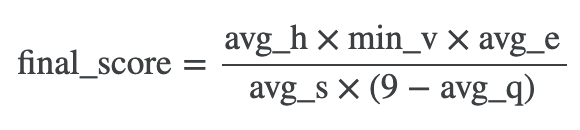
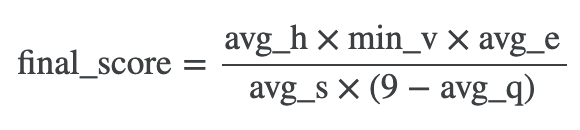

# Understanding the Scoring Components

* **Horizontal Standard Deviation (avg_h)**: This is the mean of the standard deviations between judges for each essay. For a single essay, this measures how much judges disagree about its quality. Higher values indicate more disagreement within individual essays.

* **Minimum Vertical Standard Deviation (min_v)**: This is the smallest standard deviation when looking at each judge's scores across different essays. It shows how much the most consistent judge varies their scores. Higher values mean even the most consistent judge is showing good variation.  A single highly-consistent judge will push this score to 0!

* **English Quality Score (avg_e)**: A measure between 0 and 1 of how well-formed the English is in the essays.

* **Similarity Score (avg_s)**: A measure between 0 and 1 of how similar the essays are to each other, with lower values indicating more unique essays.  This value is floored at 0.2 during scoring.

* **Average Quality (avg_q)**: The mean score across all judges and essays.

The final score combines these as: `final_score = (avg_h × min_v × avg_e) / (avg_s × (9 - avg_q))`

A single 0 score for **avg_h, min_v, or avg_e will result in an overall 0.**

See https://www.kaggle.com/code/debarshichanda/evaluation-metric-approx for notes on Similarity and English scores.

# Scoring Function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Stand-ins (unless specified we assume perfect non-similarity and English)
default_similarity_score = 0.2   #0.2 = Best possible non-similarity
default_english_score = 1.0      #1.0 = Perfect English

def calculate_final_score(grades, english_score=default_english_score, similarity_score = default_similarity_score, verbose=True):

    avg_q = np.mean(np.mean(grades, axis=1))
    avg_h = np.mean(np.std(grades, axis=1))
    min_v = min(np.std(grades, axis=0))
    avg_e = english_score
    avg_s = similarity_score

    final_score = (avg_h * min_v * avg_e) / (avg_s * (9 - avg_q))

    if verbose:
        print(f"Average Quality (avg_q): {avg_q:.2f}")
        print(f"Avg Horizontal Std (avg_h): {avg_h:.2f}")
        print(f"Min Vertical Std (min_v): {min_v:.2f}")
        print(f"English Score (avg_e): {avg_e:.2f}")
        print(f"Similarity Score (avg_s): {avg_s:.2f}")
        print(f"Final Score: {final_score:.2f}")

    return round(final_score, 2)

# Perfect Score! (30)

In [2]:
grades = np.array([
    [9, 0, 9],
    [0, 9, 9],
    [9, 9, 0],
])

calculate_final_score(grades)

Average Quality (avg_q): 6.00
Avg Horizontal Std (avg_h): 4.24
Min Vertical Std (min_v): 4.24
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 30.00


30.0

# Perfect Grades- Bad English
## Score goes to 0

In [3]:
grades = np.array([
    [9, 0, 9],
    [0, 9, 9],
    [9, 9, 0],
])

calculate_final_score(grades, english_score = 0.0)

Average Quality (avg_q): 6.00
Avg Horizontal Std (avg_h): 4.24
Min Vertical Std (min_v): 4.24
English Score (avg_e): 0.00
Similarity Score (avg_s): 0.20
Final Score: 0.00


0.0

# Perfect Grades - Bad (High) Similarity
## Hurts score but doesn't go to 0

In [4]:
grades = np.array([
    [9, 0, 9],
    [0, 9, 9],
    [9, 9, 0],
])

calculate_final_score(grades, similarity_score = 1.0)

Average Quality (avg_q): 6.00
Avg Horizontal Std (avg_h): 4.24
Min Vertical Std (min_v): 4.24
English Score (avg_e): 1.00
Similarity Score (avg_s): 1.00
Final Score: 6.00


6.0

# Consistently Fool One Judge into Giving 9's
## Score goes to 0

In [5]:
grades = np.array([
    [0, 9, 0],
    [0, 9, 9],
    [9, 9, 0],
])

calculate_final_score(grades)

Average Quality (avg_q): 5.00
Avg Horizontal Std (avg_h): 4.24
Min Vertical Std (min_v): 0.00
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 0.00


0.0

# 2 x Judges = 9, 1 x Judge = 0 (1000x random)
## Near Perfect Score! (min_v slightly less than perfect)

In [6]:
# Generate a 20x3 array where each row has two 9's and one 0
grades = np.array([np.random.permutation([9, 0, 9]) for _ in range(1000)])
print(grades)
calculate_final_score(grades)

[[0 9 9]
 [9 9 0]
 [9 9 0]
 ...
 [0 9 9]
 [0 9 9]
 [9 0 9]]
Average Quality (avg_q): 6.00
Avg Horizontal Std (avg_h): 4.24
Min Vertical Std (min_v): 4.16
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 29.41


29.41

# 2 x Judges = 0, 1 x Judge = 9 (1000x random)
## Scores only ~15/30! The lower average hurts our score!

In [7]:
# Generate a 20x3 array where each row has 1x 9 and 2x 0's
grades = np.array([np.random.permutation([9, 0, 0]) for _ in range(1000)])
print(grades)
calculate_final_score(grades)

[[9 0 0]
 [0 0 9]
 [0 9 0]
 ...
 [0 0 9]
 [0 0 9]
 [9 0 0]]
Average Quality (avg_q): 3.00
Avg Horizontal Std (avg_h): 4.24
Min Vertical Std (min_v): 4.22
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 14.93


14.93

# Random 2/3 chance of 9, 1/3 chance of 0 for each score
## Each row can have 0-3 9's
## Score of about 20!
* Simulates being able to randomly cause high scores 66% of time / rest 0's

In [8]:
grades = np.where(np.random.random((10000, 3)) < 2/3, 9, 0)
print(grades)
calculate_final_score(grades)

[[9 0 9]
 [9 0 0]
 [9 9 9]
 ...
 [0 0 0]
 [0 9 0]
 [0 9 9]]
Average Quality (avg_q): 6.02
Avg Horizontal Std (avg_h): 2.81
Min Vertical Std (min_v): 4.22
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 19.89


19.89

# Equal Chances 0, 8, 9
## Score of about 16.5

In [9]:
random_choices = np.random.random((10000, 3))
# Convert to grades: 0-0.333 -> 0, 0.333-0.666 -> 8, 0.666-1.0 -> 9
grades = np.where(random_choices < 1/3, 0, 
                 np.where(random_choices < 2/3, 8, 9))
calculate_final_score(grades)

Average Quality (avg_q): 5.66
Avg Horizontal Std (avg_h): 2.79
Min Vertical Std (min_v): 4.03
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 16.81


16.81

# Equal Chances 0.1, 8.7, 8.8, 8.9
## Score of about 18.5

In [10]:
# Define the possible grades
possible_grades = np.array([0.1, 8.7, 8.8, 8.9])

# Generate random integers between 0 and 3 (4 possibilities)
random_choices = np.random.randint(0, 4, size=(10000, 3))

# Use these integers to index into our possible_grades array
grades = possible_grades[random_choices]

calculate_final_score(grades)

Average Quality (avg_q): 6.64
Avg Horizontal Std (avg_h): 2.34
Min Vertical Std (min_v): 3.76
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 18.60


18.6

# What percentage of 9 vs. 0 is optimal if totally random?
## How high can we score without specifically targetting a given LLM?

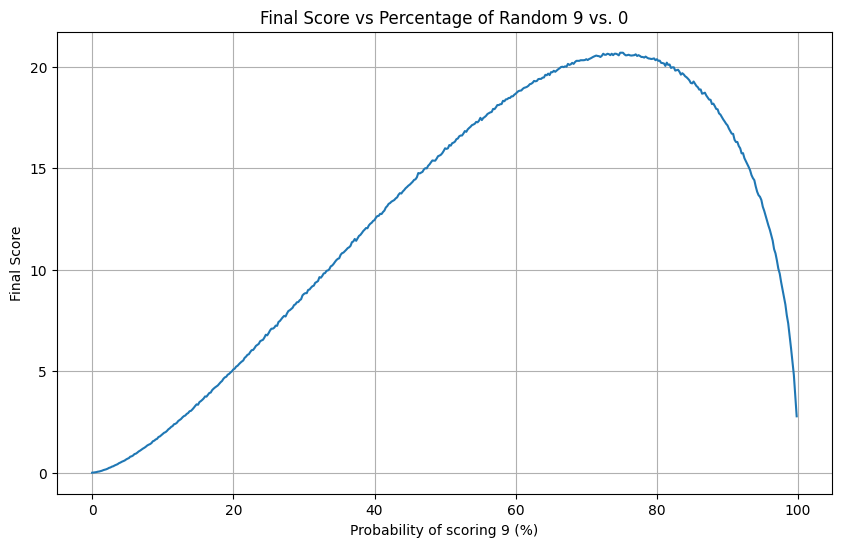

Best score of: 20.70 at 74.80% (9) / 25.20% (0)
For scores above 20:
Lowest probability 9 vs. 0: 66.60%
Highest probability 9 vs. 0: 81.80%


In [11]:
# Create array of probabilities from 0 to 1
probabilities = np.linspace(0, 1, 500, endpoint=False)
final_scores = []
# For each probability, generate grades and calculate score
best_score = 0, 0
scores_above_20 = []  # Store tuples of (score, probability) for scores > 20

for p in probabilities:
    # Generate grades with probability p of getting a 9
    grades = np.where(np.random.random((100000, 3)) < p, 9, 0)
    score = calculate_final_score(grades, verbose=False)
    if score > best_score[0]:
        best_score = score, p
    final_scores.append(score)
    if score > 20:
        scores_above_20.append((score, p))

# Add the plotting code
plt.figure(figsize=(10, 6))
plt.plot(probabilities * 100, final_scores)
plt.xlabel('Probability of scoring 9 (%)')
plt.ylabel('Final Score')
plt.grid(True)
plt.title("Final Score vs Percentage of Random 9 vs. 0")
plt.show()

# Print the original best score info
print(f"Best score of: {best_score[0]:.2f} at {best_score[1]*100:.2f}% (9) / {(100-best_score[1]*100):.2f}% (0)")

# Print the range of probabilities that achieve score > 20
if scores_above_20:
    min_prob = min(scores_above_20, key=lambda x: x[1])
    max_prob = max(scores_above_20, key=lambda x: x[1])
    print(f"For scores above 20:")
    print(f"Lowest probability 9 vs. 0: {min_prob[1]*100:.2f}%")
    print(f"Highest probability 9 vs. 0: {max_prob[1]*100:.2f}%")
else:
    print("\nNo probabilities achieved a score above 20")

# Public / Private LB score distribution for random submissions...
## Just looking at 60% 9's (rest 0's)
## Assumes actual random (which of course things aren't...)

Public LB:


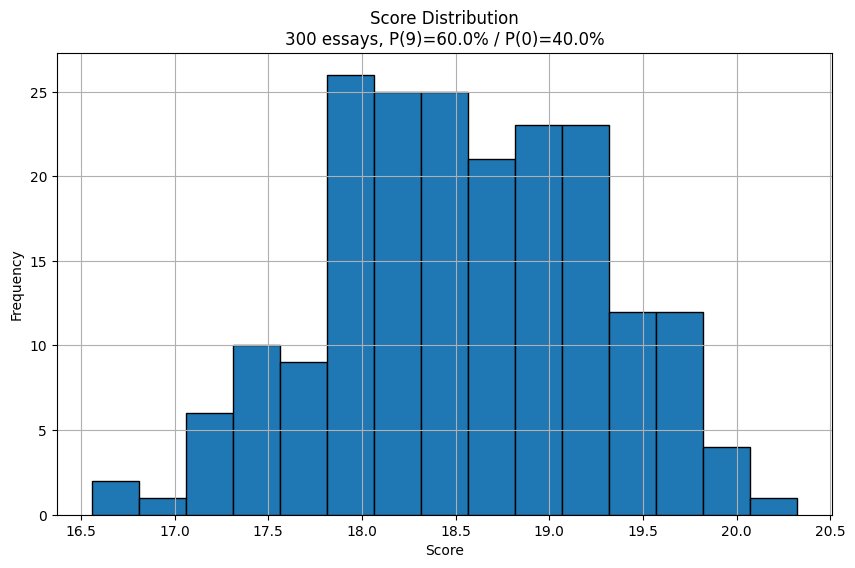

mean=18.54, std=0.71

Full Dataset:


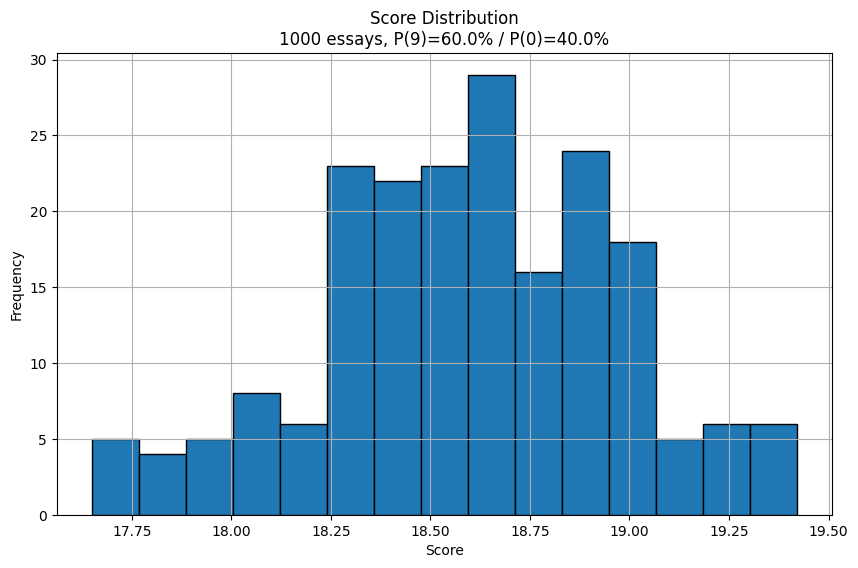

mean=18.59, std=0.38


In [12]:
def run_score_simulation(essays, submissions, p_nine):
   scores = []
   for _ in range(submissions):
       grades = np.where(np.random.random((essays, 3)) < p_nine, 9, 0) # 9s with p_nine probability, 0s otherwise
       scores.append(calculate_final_score(grades, verbose=False))
   
   plt.figure(figsize=(10, 6))
   plt.hist(scores, bins=15, edgecolor='black', color='#1f77b4')
   plt.title(f'Score Distribution\n{essays} essays, P(9)={p_nine*100}% / P(0)={100-p_nine*100}%')
   plt.xlabel('Score')
   plt.ylabel('Frequency')
   plt.grid(True)
   plt.show()
   print(f"mean={np.mean(scores):.2f}, std={np.std(scores):.2f}")
   return scores

print("Public LB:")
public_lb = run_score_simulation(essays=300, submissions=200, p_nine=0.6)

print("\nFull Dataset:") 
full_set = run_score_simulation(essays=1000, submissions=200, p_nine=0.6)

# Uniform Distibution (1000x random)
## Tends to produce about 5.5

In [13]:
grades = np.random.uniform(0, 9, size=(1000, 3))
print(grades)
calculate_final_score(grades)

[[8.13657434 2.04153185 4.97950351]
 [7.94374829 5.73968222 2.3421351 ]
 [2.60439977 0.46403933 0.10438567]
 ...
 [2.91495656 2.7751402  7.1056253 ]
 [7.83638902 7.80316936 5.07396681]
 [5.92389218 3.48632414 6.40768041]]
Average Quality (avg_q): 4.58
Avg Horizontal Std (avg_h): 1.95
Min Vertical Std (min_v): 2.60
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 5.72


5.72

# Bounded Standard Deviation Function
### Generates samples from a normal distribution defined by a standard deviation, resampling any out-of-bounds values until all samples fall within the specified range.
### Defaults to average essay quality of 4.5


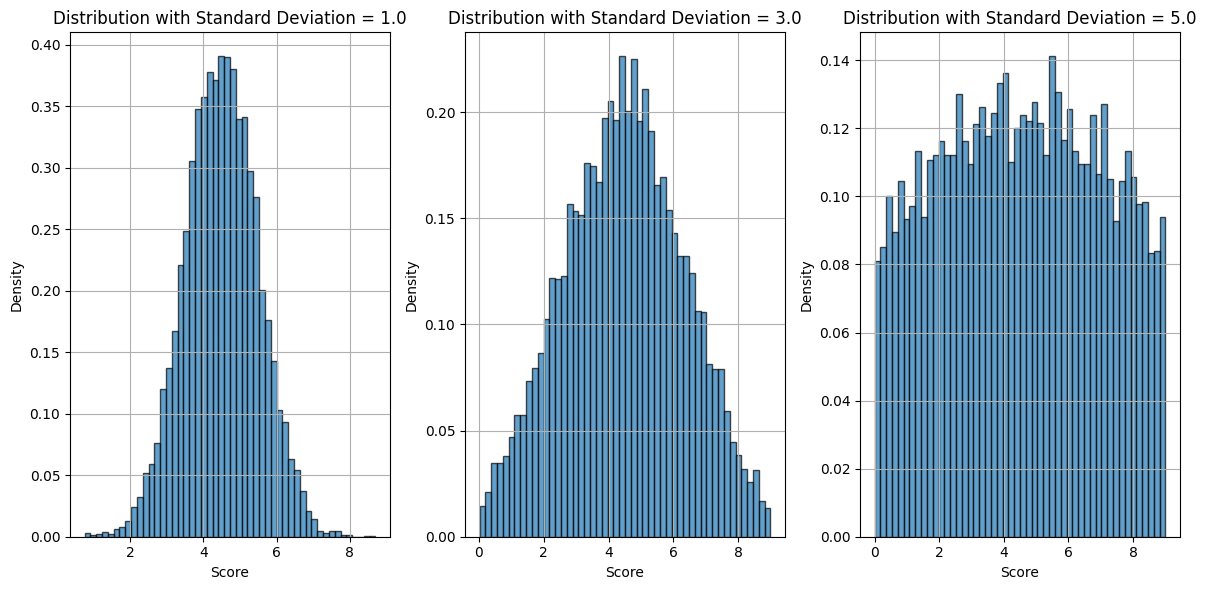

In [14]:
import numpy as np
import matplotlib.pyplot as plt

n_samples = 10000

# Function to get a single array of samples for a given standard deviation
def get_bounded_std_dev(min_grade=0, max_grade=9, std_dev_for_random=1.0, dist_center=4.5, target_samples=n_samples):
    valid_samples = []

    while len(valid_samples) < target_samples:
        grades = np.random.normal(dist_center, std_dev_for_random, size=(target_samples, 1))
        mask = (
            (grades[:, 0] >= min_grade) & (grades[:, 0] <= max_grade)
        )
        valid_batch = grades[mask]
        valid_samples.extend(valid_batch.tolist())
    
    # Ensure exactly target_samples are returned
    valid_samples = np.array(valid_samples[:target_samples])
    return valid_samples


# Generate two sets of samples for two standard deviations
samples_std_1 = get_bounded_std_dev(std_dev_for_random=1.0, target_samples=10000).flatten()
samples_std_2 = get_bounded_std_dev(std_dev_for_random=2.0, target_samples=10000).flatten()
samples_std_3 = get_bounded_std_dev(std_dev_for_random=5.0, target_samples=10000).flatten()

# Plotting the two distributions side by side
plt.figure(figsize=(12, 6))

# Chart for Std Dev = 1.0
plt.subplot(1, 3, 1)
plt.hist(samples_std_1, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.title('Distribution with Standard Deviation = 1.0')
plt.xlabel('Score')
plt.ylabel('Density')
plt.grid(True)

# Chart for Std Dev = 3.0
plt.subplot(1, 3, 2)
plt.hist(samples_std_2, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.title('Distribution with Standard Deviation = 3.0')
plt.xlabel('Score')
plt.ylabel('Density')
plt.grid(True)

# Chart for Std Dev = 5.0
plt.subplot(1, 3, 3)
plt.hist(samples_std_3, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.title('Distribution with Standard Deviation = 5.0')
plt.xlabel('Score')
plt.ylabel('Density')
plt.grid(True)


plt.tight_layout()
plt.show()

# Normal Distribution with a Standard Deviation of 1
## Tends to produce about 0.8
### Grades clustered around 4.5 hurt both variance values

In [15]:
first_judge = get_bounded_std_dev(std_dev_for_random=1.0) 
second_judge = get_bounded_std_dev(std_dev_for_random=1.0) 
third_judge = get_bounded_std_dev(std_dev_for_random=1.0) 
grades = np.column_stack((first_judge, second_judge, third_judge))

print(grades)
calculate_final_score(grades)

[[3.19244352 5.56916194 4.39629686]
 [5.24868202 6.04623919 3.84628743]
 [3.97185177 5.98052953 3.34160918]
 ...
 [3.82223702 5.04794969 3.91353203]
 [3.66515657 4.21141611 3.65378632]
 [3.92318134 3.9630888  5.14180079]]
Average Quality (avg_q): 4.50
Avg Horizontal Std (avg_h): 0.73
Min Vertical Std (min_v): 1.00
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 0.81


0.81

# Normal Distribution with a Standard Deviation of 3
## Tends to produce about 4
### Wider distribution = better variance
## Idea: Highly polarizing essays may help score...

In [16]:
first_judge = get_bounded_std_dev(std_dev_for_random=3.0, dist_center=4.5) 
second_judge = get_bounded_std_dev(std_dev_for_random=3.0, dist_center=4.5) 
third_judge = get_bounded_std_dev(std_dev_for_random=3.0, dist_center=4.5) 
grades = np.column_stack((first_judge, second_judge, third_judge))

print(grades)
calculate_final_score(grades)

[[7.22375852 4.71572911 4.09775772]
 [3.6099033  5.49587792 1.7969903 ]
 [2.8597745  7.36068019 2.3490813 ]
 ...
 [1.022723   5.27925396 3.51014933]
 [3.62714875 3.66555631 2.04877356]
 [8.44200316 5.80252721 4.55065214]]
Average Quality (avg_q): 4.51
Avg Horizontal Std (avg_h): 1.65
Min Vertical Std (min_v): 2.22
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 4.07


4.07

# Standard Deviation of 3 / Average Essay Quality = 7.5
## Score improves to ~4.8

In [17]:
first_judge = get_bounded_std_dev(std_dev_for_random=3.0, dist_center=7.5) 
second_judge = get_bounded_std_dev(std_dev_for_random=3.0, dist_center=7.5) 
third_judge = get_bounded_std_dev(std_dev_for_random=3.0, dist_center=7.5) 
grades = np.column_stack((first_judge, second_judge, third_judge))

print(grades)
calculate_final_score(grades)

[[8.92527567 7.24469254 6.38093057]
 [7.26786023 5.79624622 6.65656156]
 [6.46732085 8.63631183 5.94138592]
 ...
 [5.34074758 7.65665452 2.84783751]
 [6.49638401 5.06095518 7.34390927]
 [3.95644452 2.9716262  1.73596052]]
Average Quality (avg_q): 6.05
Avg Horizontal Std (avg_h): 1.45
Min Vertical Std (min_v): 2.00
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 4.93


4.93

# Single Controlled Judge: 50% '9' / Rest '0' (other judges std dev of 3)
## Score: ~6.1

In [18]:
chance_nine = 0.5
chance_zero = 1 - chance_nine
controlled_judge = np.random.choice([0, 9], size=n_samples, p=[chance_zero, chance_nine])

first_judge = get_bounded_std_dev(std_dev_for_random=3.0) 
second_judge = get_bounded_std_dev(std_dev_for_random=3.0) 

grades = np.column_stack((first_judge, second_judge, controlled_judge))

calculate_final_score(grades)

Average Quality (avg_q): 4.49
Avg Horizontal Std (avg_h): 2.46
Min Vertical Std (min_v): 2.23
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 6.08


6.08

# Single Controlled Judge: 85% '9' / Rest '0' (other judges std dev of 3)
## Score: ~8.0

In [19]:
chance_nine = 0.85
chance_zero = 1 - chance_nine
controlled_judge = np.random.choice([0, 9], size=n_samples, p=[chance_zero, chance_nine])

first_judge = get_bounded_std_dev(std_dev_for_random=3.0) 
second_judge = get_bounded_std_dev(std_dev_for_random=3.0) 

grades = np.column_stack((first_judge, second_judge, controlled_judge))

calculate_final_score(grades)

Average Quality (avg_q): 5.55
Avg Horizontal Std (avg_h): 2.47
Min Vertical Std (min_v): 2.21
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 7.92


7.92

# Single Controlled Judge: 92% '9' / Rest '0' (other judges std dev of 3)
## Score: ~8.4 (!?)

In [20]:
chance_nine = 0.92
chance_zero = 1 - chance_nine
controlled_judge = np.random.choice([0, 9], size=n_samples, p=[chance_zero, chance_nine])

first_judge = get_bounded_std_dev(std_dev_for_random=3.0) 
second_judge = get_bounded_std_dev(std_dev_for_random=3.0) 

grades = np.column_stack((first_judge, second_judge, controlled_judge))

calculate_final_score(grades)

Average Quality (avg_q): 5.74
Avg Horizontal Std (avg_h): 2.48
Min Vertical Std (min_v): 2.22
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 8.45


8.45

# Let's Chart This...

In [21]:
def chart_for_single_controlled_judge(controlled_judge_low_score = 0, use_random_for_controlled_judge_low_score = False, controlled_judge_high_score = 9, std_dev_for_random = 3.0, dist_center=4.5):
    n_samples = 10000  # Number of essays/samples
    
    # Varying the probability of the controlled judge scoring a 9
    probabilities = np.linspace(0, 1, 100)  # From 0% to 100% chance of scoring High
    final_scores = []
    
    best_score_and_ratio = 0, 0
    for chance_high in probabilities:
        chance_low = 1 - chance_high

        first_judge = get_bounded_std_dev(std_dev_for_random=std_dev_for_random, dist_center=dist_center) 
        second_judge = get_bounded_std_dev(std_dev_for_random=std_dev_for_random, dist_center=dist_center)

        # Third judge's controlled scores

        if use_random_for_controlled_judge_low_score:

            controlled_judge = []
            for _ in range(n_samples):
                if np.random.random() < chance_low:
                    # Generate new std dev value for each low score case
                    sd_value = get_bounded_std_dev(std_dev_for_random=std_dev_for_random, target_samples=1, dist_center=4.5)[0][0]
                    controlled_judge.append(sd_value)
                else:
                    controlled_judge.append(controlled_judge_high_score)
            
            controlled_judge = np.array(controlled_judge)

        else:
            #assigns controlled_judge_low_score scores for "low"
            controlled_judge = np.random.choice([controlled_judge_low_score, controlled_judge_high_score], size=n_samples, p=[chance_low, chance_high])
            
        
        # Combine all grades into one matrix
        grades = np.column_stack((first_judge, second_judge, controlled_judge))
        
        # Calculate final score
        final_score = calculate_final_score(grades, verbose=False)
        final_scores.append(final_score)
    
        if final_score > best_score_and_ratio[0]:
            best_score_and_ratio = final_score, chance_high
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(probabilities, final_scores, marker='o')
    plt.title('Effect of Controlled Third Judge Probability on Final Score')
    plt.xlabel('Probability of Third Judge Scoring 9')
    plt.ylabel('Final Score')
    plt.grid(True)
    plt.show()
    print (f"Judges 1, 2 random between 0 and 9 with standard deviation of {std_dev_for_random}")
    print (f"Center of Distribution for random scores: {dist_center}")
    
    if use_random_for_controlled_judge_low_score:
        controlled_judge_low_score_text = f"(random with std. dev of {std_dev_for_random})"
    else:
        controlled_judge_low_score_text = f"{controlled_judge_low_score}"
        
    print (f"Judge 3 assigned {controlled_judge_low_score_text} or {controlled_judge_high_score} at charted ratios")
    print (f"Best score: {best_score_and_ratio[0]:.2f} with {controlled_judge_high_score} being assigned {best_score_and_ratio[1] * 100:.2f}% of the time\n\n")

# Chart a few different distributions
## If you can assign your judge 0 or 9 - looks like you want to give them mostly 9's...

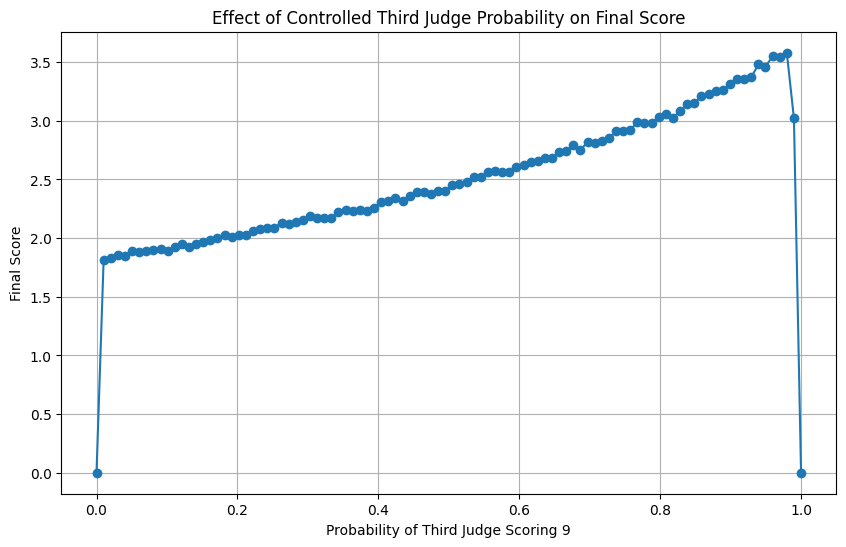

Judges 1, 2 random between 0 and 9 with standard deviation of 1
Center of Distribution for random scores: 4.5
Judge 3 assigned 0 or 9 at charted ratios
Best score: 3.58 with 9 being assigned 97.98% of the time




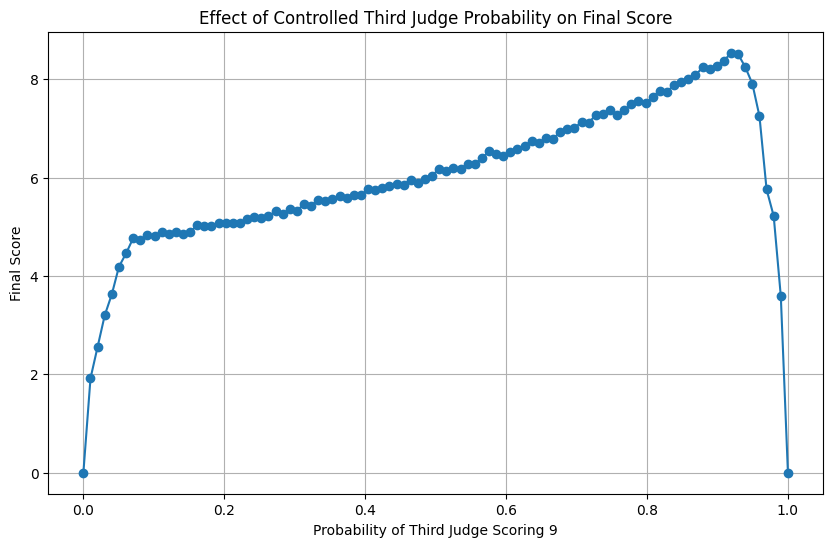

Judges 1, 2 random between 0 and 9 with standard deviation of 3
Center of Distribution for random scores: 4.5
Judge 3 assigned 0 or 9 at charted ratios
Best score: 8.54 with 9 being assigned 91.92% of the time




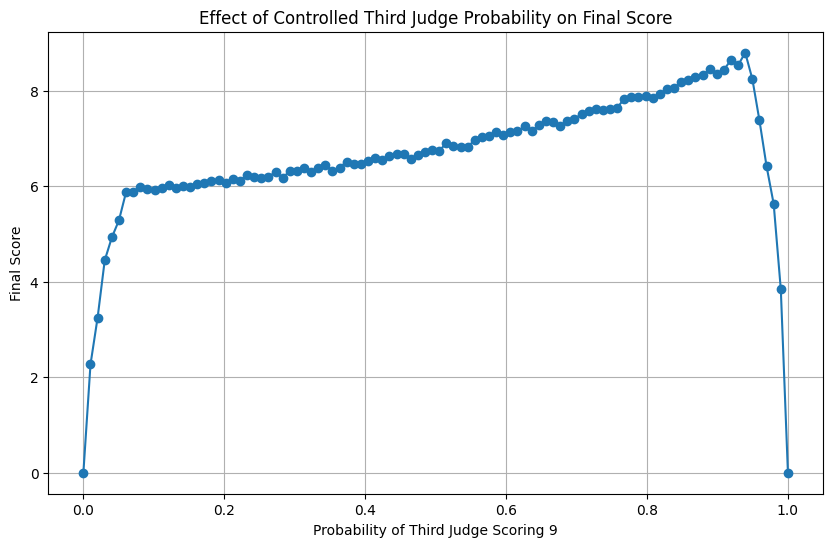

Judges 1, 2 random between 0 and 9 with standard deviation of 3
Center of Distribution for random scores: 6.5
Judge 3 assigned 0 or 9 at charted ratios
Best score: 8.80 with 9 being assigned 93.94% of the time




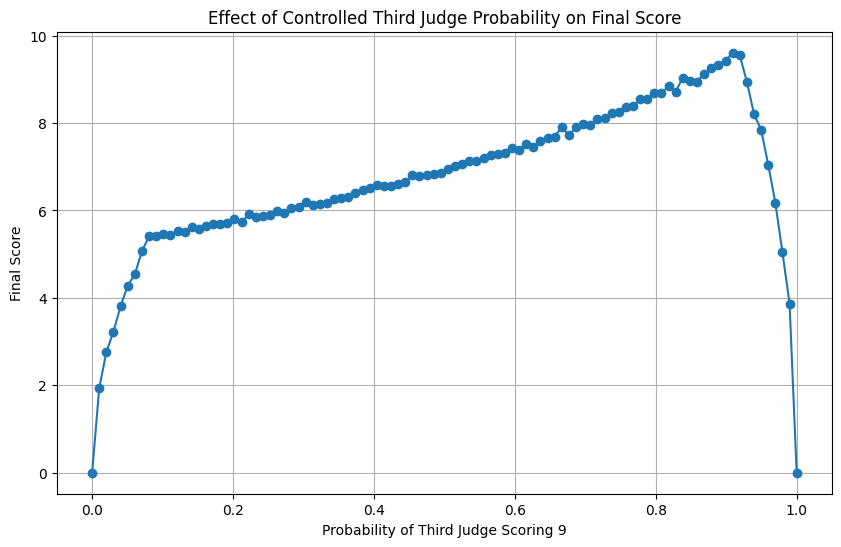

Judges 1, 2 random between 0 and 9 with standard deviation of 5
Center of Distribution for random scores: 4.5
Judge 3 assigned 0 or 9 at charted ratios
Best score: 9.61 with 9 being assigned 90.91% of the time




In [22]:
#std dev 1
chart_for_single_controlled_judge(controlled_judge_low_score = 0, controlled_judge_high_score = 9, std_dev_for_random = 1)

#std dev 3
chart_for_single_controlled_judge(controlled_judge_low_score = 0, controlled_judge_high_score = 9, std_dev_for_random = 3)

#std dev 3 / higher scoring average essays for non-controlled
chart_for_single_controlled_judge(controlled_judge_low_score = 0, controlled_judge_high_score = 9, std_dev_for_random = 3, dist_center=6.5)

#std dev 5
chart_for_single_controlled_judge(controlled_judge_low_score = 0, controlled_judge_high_score = 9, std_dev_for_random = 5)

# Things are a bit different depending on numbers you can target...
### Scores are lower though...

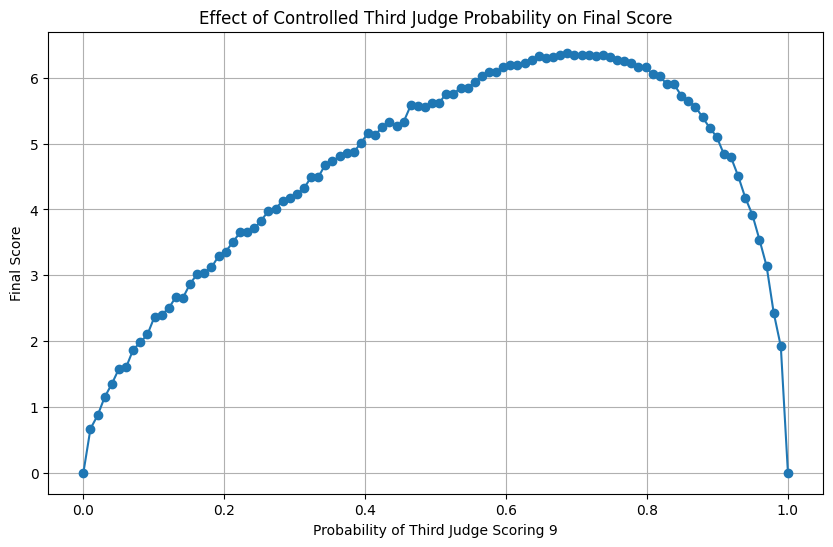

Judges 1, 2 random between 0 and 9 with standard deviation of 3
Center of Distribution for random scores: 4.5
Judge 3 assigned 4.5 or 9 at charted ratios
Best score: 6.38 with 9 being assigned 68.69% of the time




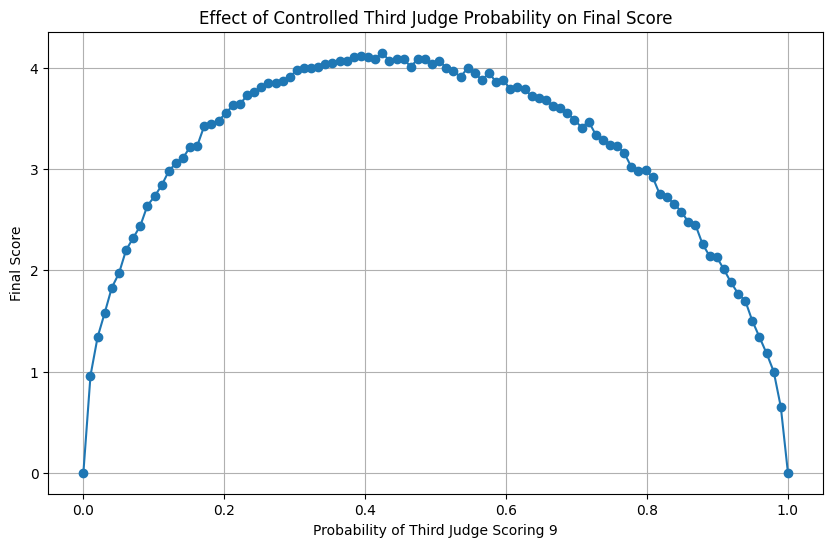

Judges 1, 2 random between 0 and 9 with standard deviation of 3
Center of Distribution for random scores: 4.5
Judge 3 assigned 0 or 4.5 at charted ratios
Best score: 4.15 with 4.5 being assigned 42.42% of the time




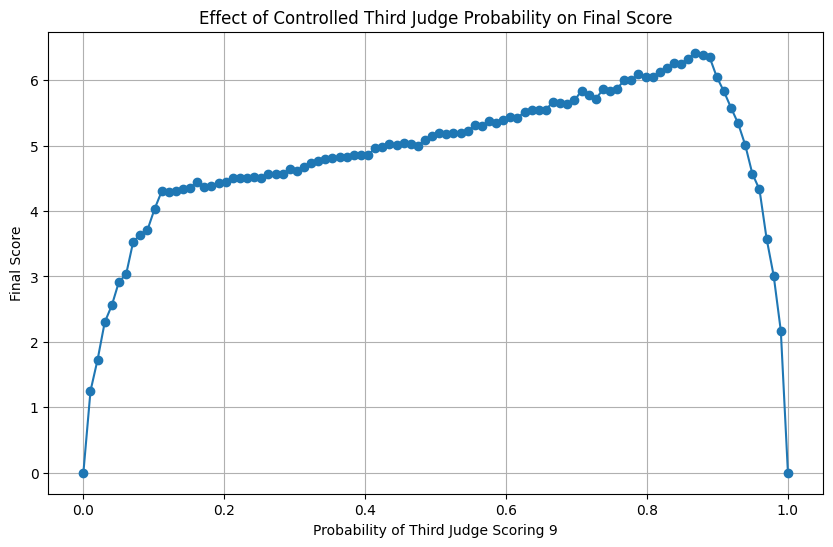

Judges 1, 2 random between 0 and 9 with standard deviation of 3
Center of Distribution for random scores: 4.5
Judge 3 assigned 1 or 8 at charted ratios
Best score: 6.42 with 8 being assigned 86.87% of the time




In [23]:
chart_for_single_controlled_judge(controlled_judge_low_score = 4.5, controlled_judge_high_score = 9, std_dev_for_random = 3)

chart_for_single_controlled_judge(controlled_judge_low_score = 0, controlled_judge_high_score = 4.5, std_dev_for_random = 3)

chart_for_single_controlled_judge(controlled_judge_low_score = 1, controlled_judge_high_score = 8, std_dev_for_random = 3)

# Controlled Judge assigned 9 or is random with the others
* Intended to simulate scenario where controlled judge can be forced to 9, but not 0
* Ratio reflects how often forced 9 exploit is used vs. no exploit

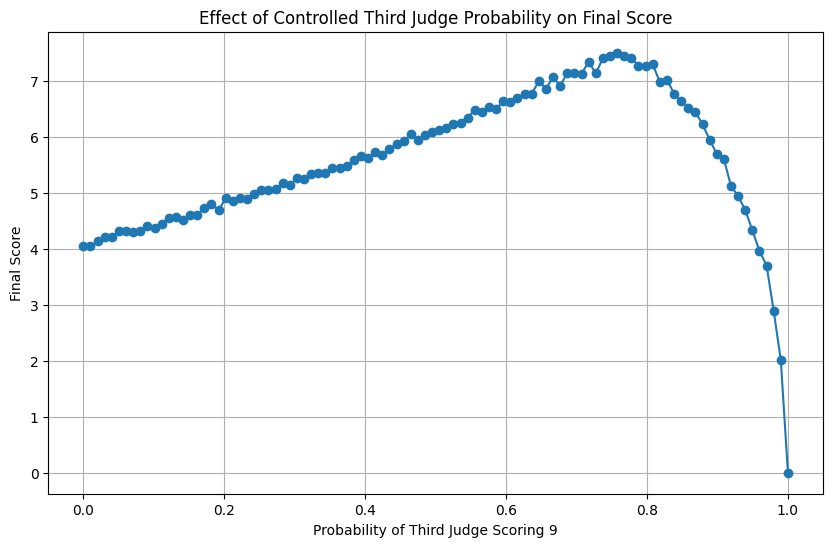

Judges 1, 2 random between 0 and 9 with standard deviation of 3
Center of Distribution for random scores: 4.5
Judge 3 assigned (random with std. dev of 3) or 9 at charted ratios
Best score: 7.50 with 9 being assigned 75.76% of the time




In [24]:
chart_for_single_controlled_judge(use_random_for_controlled_judge_low_score = True, controlled_judge_high_score = 9, std_dev_for_random = 3)

# Top Secret LB 30 Attack Plan
## How do we determine if individual attacks work?
* We again assume generated text has perfect avg_e and avg_s scores (not covered here)

In [25]:
def score_from_probs(patterns_and_probs, verbose=True):
    sample_count = 10000
    grades = np.vstack([
       np.array([pattern] * int(sample_count * prop))
       for pattern, prop in patterns_and_probs
    ])
    score = calculate_final_score(grades, verbose=verbose)
    if not verbose: print(round(score, 2), "\n")
    else: print()

# Step 1: Baseline - Goal: LB 0.0
### Essay scores of 9-9-9, 9-9-9, 0-0-0 
* This assumes we have come up with baseline approaches to make all models score 0's or 9's for a given essay
* We will adjust the 9-9-9 basline with attacks to selectively convert some 9's to 0's
* The 0-0-0 scores are required to evaluate our 1st and 2nd attack (otherwise we fail vertical variance)
* This produces a baseline 0 LB score!

In [26]:
#-----Baseline submission----- (LB 0)

print("Baseline: 9-9-9, 9-9-9, 0-0-0:\n")
score_from_probs ([
   ([9, 9, 9], 0.33), # 9-9-9 baseline
   ([9, 9, 9], 0.33), # 9-9-9 baseline
   ([0, 0, 0], 0.33), # 0-0-0 baseline
])

Baseline: 9-9-9, 9-9-9, 0-0-0:

Average Quality (avg_q): 6.00
Avg Horizontal Std (avg_h): 0.00
Min Vertical Std (min_v): 4.24
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 0.00



# Step 2: Attack 1 - Goal: LB 7.5
* We attempt attack variations in an effort to perfect our first attack
* Converting 3 judges to 0 yields lands us back at LB 0
* If we convert 2 judges to 0 - we get LB 6
* **If we convert only 1 judge to 0 - we get LB 7.5 (perfect!)**

In [27]:
print("Attack 1 / Convert 3 judges to 0:\n")
score_from_probs ([
   ([0, 0, 0], 0.33), # 9-9-9 baseline + Attack 1 converts all 3 judges to 0
   ([9, 9, 9], 0.33), # 9-9-9 baseline
   ([0, 0, 0], 0.33), # 0-0-0 baseline
])

print("Attack 1 / Convert 2 judges to 0:\n")
score_from_probs ([
   ([9, 0, 0], 0.33), # 9-9-9 baseline + Attack 1 converts 2 judges to 0
   ([9, 9, 9], 0.33), # 9-9-9 baseline 
   ([0, 0, 0], 0.33), # 0-0-0 baseline
])

#the best for attack 1!
print("Attack 1 / Convert 1 judge to 0:\n")
score_from_probs ([
   ([9, 9, 0], 0.33), # 9-9-9 baseline + Attack 1 converts 1 judge to 0
   ([9, 9, 9], 0.33), # 9-9-9 baseline  
   ([0, 0, 0], 0.33), # 0-0-0 baseline
])

Attack 1 / Convert 3 judges to 0:

Average Quality (avg_q): 3.00
Avg Horizontal Std (avg_h): 0.00
Min Vertical Std (min_v): 4.24
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 0.00

Attack 1 / Convert 2 judges to 0:

Average Quality (avg_q): 4.00
Avg Horizontal Std (avg_h): 1.41
Min Vertical Std (min_v): 4.24
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 6.00

Attack 1 / Convert 1 judge to 0:

Average Quality (avg_q): 5.00
Avg Horizontal Std (avg_h): 1.41
Min Vertical Std (min_v): 4.24
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 7.50



# Step 3: Attack 2 - Goal: LB 12.0
* We keep our perfected attack 1 (9-9-9 baseline + 1 judge converted to 0)
* For attack 2 we explore a few scenarios
* **Our perfect attack 2 converts a single new judge to 0 for an LB of 12**
* Note that we maintain the 0-0-0 submission for the last 33% (otherwise vertical variance = 0)

In [28]:
# Attack 2:
print("Attack 2 / Convert same judge as attack 1 to 0:\n")
score_from_probs ([
   ([9, 9, 0], 0.33),  # 9-9-9 baseline + perfected Attack 1
   ([9, 9, 0], 0.33),  # 9-9-9 baseline + Attack 2 converts same judge to 0 as Attack 1
   ([0, 0, 0], 0.33),  # 0-0-0 baseline
])

print("Attack 2 / Convert same judge at attack 1 + 1 new judge to 0:\n")
score_from_probs ([
   ([9, 9, 0], 0.33), # 9-9-9 baseline + perfected Attack 1
   ([0, 9, 0], 0.33), # 9-9-9 baseline + Attack 2 converts same judge at attack 1 + 1 new judge to 0
   ([0, 0, 0], 0.33), # 0-0-0 baseline
])

print("Attack 2 / Convert 2 new judges to 0:\n")
score_from_probs ([
   ([9, 9, 0], 0.33), # 9-9-9 baseline + perfected Attack 1
   ([0, 0, 9], 0.33), # 9-9-9 baseline + Attack 2 converts 2 new judges to 0
   ([0, 0, 0], 0.33), # 0-0-0 baseline
])

#the best for attack 2!
print("Attack 2 / Convert just 1 new judge to 0:\n")
score_from_probs ([
   ([9, 9, 0], 0.33), # 9-9-9 baseline + perfected Attack 1
   ([9, 0, 9], 0.33), # 9-9-9 baseline + Attack 2 converts 1 new judge to 0
   ([0, 0, 0], 0.33), # 0-0-0 baseline
])

Attack 2 / Convert same judge as attack 1 to 0:

Average Quality (avg_q): 4.00
Avg Horizontal Std (avg_h): 2.83
Min Vertical Std (min_v): 0.00
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 0.00

Attack 2 / Convert same judge at attack 1 + 1 new judge to 0:

Average Quality (avg_q): 3.00
Avg Horizontal Std (avg_h): 2.83
Min Vertical Std (min_v): 0.00
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 0.00

Attack 2 / Convert 2 new judges to 0:

Average Quality (avg_q): 3.00
Avg Horizontal Std (avg_h): 2.83
Min Vertical Std (min_v): 4.24
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 10.00

Attack 2 / Convert just 1 new judge to 0:

Average Quality (avg_q): 4.00
Avg Horizontal Std (avg_h): 2.83
Min Vertical Std (min_v): 4.24
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 12.00



# Step 4: Attack 3 - Goal: LB 30.0!
* We keep our perfected attacks 1 and 2
* We change out final baseline from 0-0-0 to 9-9-9 (and apply our attack to that)
* **If we manage to convert just the remaining judge to 0 - we get our LB 30!**

In [29]:
# Attack 3: removing all 0's
print("Attack 3 / Convert same judge as attack 1 or 2 to 0:\n")
score_from_probs ([
   ([9, 9, 0], 0.33), # 9-9-9 baseline + perfected Attack 1
   ([9, 0, 9], 0.33), # 9-9-9 baseline + perfected Attack 2
   ([9, 0, 9], 0.33), # 9-9-9 baseline + Attack 3 converts same judge as Attack 1 or 2 to 0
])

print("Attack 3 / Converts a judge from attack 1 or 2 + remaining new judge to 0:\n")
score_from_probs ([
   ([9, 9, 0], 0.33), # 9-9-9 baseline + perfected Attack 1
   ([9, 0, 9], 0.33), # 9-9-9 baseline + perfected Attack 2
   ([0, 0, 9], 0.33), # 9-9-9 baseline + Attack 3 a judge from Attack 1 or 2 + remaining new judge to 0's
])

#the best for attack 3!
print("Attack 3 / Convert just remaining new judge to 0:\n")
score_from_probs ([
   ([9, 9, 0], 0.33), # 9-9-9 baseline + perfected Attack 1
   ([9, 0, 9], 0.33), # 9-9-9 baseline + perfected Attack 2
   ([0, 9, 9], 0.33), # 9-9-9 baseline + Attack 3 converts remaining new judge to 0
])

Attack 3 / Convert same judge as attack 1 or 2 to 0:

Average Quality (avg_q): 6.00
Avg Horizontal Std (avg_h): 4.24
Min Vertical Std (min_v): 0.00
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 0.00

Attack 3 / Converts a judge from attack 1 or 2 + remaining new judge to 0:

Average Quality (avg_q): 5.00
Avg Horizontal Std (avg_h): 4.24
Min Vertical Std (min_v): 4.24
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 22.50

Attack 3 / Convert just remaining new judge to 0:

Average Quality (avg_q): 6.00
Avg Horizontal Std (avg_h): 4.24
Min Vertical Std (min_v): 4.24
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 30.00



# Easy Option: Single Judge Control for LB 22.5!
* Assume we have method to generate all 9's or 0's + full control of 1 judge
* For 2/3 entries - we just use 9-9-9 baseline + flip our controlled judge to 0
* For 1/3 entries - we use 0-0-0 baseline + flip our controlled judge to 9

### Score components are perfect except average quality

In [30]:
score_from_probs ([
   ([0, 9, 9], 0.33), # 9-9-9 baseline + attack to make Judge 1 to produce 0
   ([0, 9, 9], 0.33), # 9-9-9 baseline + attack to make Judge 1 to produce 0
   ([9, 0, 0], 0.33), # 0-0-0 baseline + attack to make Judge 1 to produce 9
])

Average Quality (avg_q): 5.00
Avg Horizontal Std (avg_h): 4.24
Min Vertical Std (min_v): 4.24
English Score (avg_e): 1.00
Similarity Score (avg_s): 0.20
Final Score: 22.50

